In [1]:
import numpy as np

def ComputeSeams(energyMap, direction='vertical'):
    """
    Compute cumulative seam energies and backtracking indices.
    
    Parameters:
        energyMap: 2D numpy array of energy values.
        direction: 'vertical' (default) for top-to-bottom seams, or 'horizontal' for left-to-right seams.
    
    Returns:
        energySums: Cumulative energy map.
        energySumsCoords: Backtracking coordinate matrix.
        seam: Optimal seam (vertical: one column index per row; horizontal: one row index per column).
    """
    row, col = energyMap.shape

    if direction == 'vertical':
        # Vertical seam: process rows (top-to-bottom)
        energySums = np.copy(energyMap)
        energySumsCoords = np.zeros((row, col), dtype=int)
        
        for i in range(1, row):
            for j in range(col):
                # Handle boundaries
                if j == 0:
                    prev_vals = energySums[i - 1, j:j+2]
                    offset = 0
                elif j == col - 1:
                    prev_vals = energySums[i - 1, j-1:j+1]
                    offset = j - 1
                else:
                    prev_vals = energySums[i - 1, j-1:j+2]
                    offset = j - 1

                min_val = np.min(prev_vals)
                min_index = np.argmin(prev_vals)
                energySums[i, j] += min_val
                energySumsCoords[i, j] = offset + min_index

        # Backtracking: find the vertical seam (one column per row)
        seam = np.zeros(row, dtype=int)
        seam[-1] = np.argmin(energySums[-1])
        for i in range(row - 2, -1, -1):
            seam[i] = energySumsCoords[i + 1, seam[i + 1]]
            
        return energySums, energySumsCoords, seam

    elif direction == 'horizontal':
        # Horizontal seam: process columns (left-to-right)
        energySums = np.copy(energyMap)
        energySumsCoords = np.zeros((row, col), dtype=int)
        
        for j in range(1, col):
            for i in range(row):
                # Handle boundaries for rows when moving horizontally
                if i == 0:
                    prev_vals = energySums[i:i+2, j-1]
                    offset = i
                elif i == row - 1:
                    prev_vals = energySums[i-1:i+1, j-1]
                    offset = i - 1
                else:
                    prev_vals = energySums[i-1:i+2, j-1]
                    offset = i - 1

                min_val = np.min(prev_vals)
                min_index = np.argmin(prev_vals)
                energySums[i, j] += min_val
                energySumsCoords[i, j] = offset + min_index

        # Backtracking: find the horizontal seam (one row per column)
        seam = np.zeros(col, dtype=int)
        seam[-1] = np.argmin(energySums[:, -1])
        for j in range(col - 2, -1, -1):
            seam[j] = energySumsCoords[seam[j + 1], j + 1]
            
        return energySums, energySumsCoords, seam

    else:
        raise ValueError("direction must be either 'vertical' or 'horizontal'")

In [2]:

import numpy as np
import matplotlib.image as mpimage
import matplotlib.pyplot as plt
from scipy import signal

def rgb2gray(image):
    """Convert an RGB image to grayscale."""
    return np.dot(image[..., :3], [0.2989, 0.5870, 0.1140])

def FindEnergyMap(image):
    """
    Computes the energy map e1(I) = |∂I/∂x| + |∂I/∂y|
    using standard Sobel filters for x and y derivatives.
    """
    gray = rgb2gray(image)
    
    sobel_x = np.array([[-1,  0,  1],
                        [-2,  0,  2],
                        [-1,  0,  1]])
    
    sobel_y = np.array([[-1, -2, -1],
                        [ 0,  0,  0],
                        [ 1,  2,  1]])
    
    # Convolve with each kernel
    # 'same' keeps output size = input size
    # 'symm' handles boundaries more gracefully
    dx = signal.convolve2d(gray, sobel_x, mode='same', boundary='symm')
    dy = signal.convolve2d(gray, sobel_y, mode='same', boundary='symm')
    
    # e1(I) = |∂I/∂x| + |∂I/∂y|
    energyMap = np.abs(dx) + np.abs(dy)
    return energyMap


def ComputeSeams(energyMap, direction='vertical'):
    """
    Compute cumulative seam energies and backtracking indices.
    
    Parameters:
        energyMap: 2D numpy array of energy values.
        direction: 'vertical' (default) for top-to-bottom seams or 
                   'horizontal' for left-to-right seams.
    
    Returns:
        energySums: The cumulative energy map.
        energySumsCoords: Backtracking matrix storing the index of the predecessor.
        seam: The optimal seam (vertical: one column per row; horizontal: one row per column).
    """
    row, col = energyMap.shape

    if direction == 'vertical':
        energySums = np.copy(energyMap)
        energySumsCoords = np.zeros((row, col), dtype=int)
        
        # Process from the second row to the last row
        for i in range(1, row):
            for j in range(col):
                # For left boundary, only consider pixel directly above and the one to the right.
                if j == 0:
                    prev_vals = energySums[i - 1, j:j+2]
                    offset = 0
                # For right boundary, consider the pixel above and the one to the left.
                elif j == col - 1:
                    prev_vals = energySums[i - 1, j-1:j+1]
                    offset = j - 1
                else:
                    prev_vals = energySums[i - 1, j-1:j+2]
                    offset = j - 1

                min_val = np.min(prev_vals)
                min_index = np.argmin(prev_vals)
                energySums[i, j] += min_val
                energySumsCoords[i, j] = offset + min_index

        # Backtracking: start from the bottom row and work upward.
        seam = np.zeros(row, dtype=int)
        seam[-1] = np.argmin(energySums[-1])
        for i in range(row - 2, -1, -1):
            seam[i] = energySumsCoords[i + 1, seam[i + 1]]
            
        return energySums, energySumsCoords, seam

    elif direction == 'horizontal':
        energySums = np.copy(energyMap)
        energySumsCoords = np.zeros((row, col), dtype=int)
        
        # Process from the second column to the last column.
        for j in range(1, col):
            for i in range(row):
                # For top boundary, consider the same row and the one below.
                if i == 0:
                    prev_vals = energySums[i:i+2, j-1]
                    offset = i
                # For bottom boundary, consider the one above and the same row.
                elif i == row - 1:
                    prev_vals = energySums[i-1:i+1, j-1]
                    offset = i - 1
                else:
                    prev_vals = energySums[i-1:i+2, j-1]
                    offset = i - 1

                min_val = np.min(prev_vals)
                min_index = np.argmin(prev_vals)
                energySums[i, j] += min_val
                energySumsCoords[i, j] = offset + min_index

        # Backtracking: start from the rightmost column and move leftward.
        seam = np.zeros(col, dtype=int)
        seam[-1] = np.argmin(energySums[:, -1])
        for j in range(col - 2, -1, -1):
            seam[j] = energySumsCoords[seam[j + 1], j + 1]
            
        return energySums, energySumsCoords, seam

    else:
        raise ValueError("direction must be either 'vertical' or 'horizontal'")



In [3]:
import sys
from imageio import imread
import numpy as np

import matplotlib.pyplot as plt

def reduceImage(image, numSeams):
    """
    Reduce the image size by repeatedly removing the seam (vertical or horizontal)
    with the lower cumulative energy.
    
    Parameters:
        image: Input RGB image as a numpy array.
        numSeams: Total number of seams to remove (each removal reduces width or height).
    
    Returns:
        newImage: The resized image after seam removals.
    """
    newImage = np.copy(image)
    # For visualization purposes we also maintain a copy that marks the seams.
    seamPath = np.copy(image)
    redVal = 256  # Used to mark seams in decreasing red intensity

    for z in range(numSeams):
        energyMap = FindEnergyMap(newImage)
        # Compute vertical seam (top-to-bottom)
        energySums_v, coords_v, seam_v = ComputeSeams(energyMap, direction='vertical')
        # Compute horizontal seam (left-to-right)
        energySums_h, coords_h, seam_h = ComputeSeams(energyMap, direction='horizontal')
        
        # Cost for vertical seam is the min value in the last row
        cost_v = np.min(energySums_v[-1])
        # Cost for horizontal seam is the min value in the rightmost column
        cost_h = np.min(energySums_h[:, -1])
        
        # Choose the seam with lower cost
        if cost_v <= cost_h:
            seamType = 'vertical'
        else:
            seamType = 'horizontal'
            
        redVal -= 1
        print("Iteration {}: image shape: {}, removing {} seam (cost: {:.2f} vs. {:.2f})".format(
            z, newImage.shape, seamType, cost_v, cost_h))
        
        if seamType == 'vertical':
            # Remove vertical seam: remove one pixel per row.
            rows, cols, _ = newImage.shape
            for i in range(rows):
                j = seam_v[i]  # Column to remove in row i
                # Mark the seam on seamPath (for visualization)
                seamPath[i, j, 0] = redVal
                seamPath[i, j, 1] = 0
                seamPath[i, j, 2] = 0
                # Shift pixels left from column j onward
                newImage[i, j:cols-1] = newImage[i, j+1:cols]
                newImage[i, cols-1] = 0  # Optional: clear last column
            # Update image width by slicing
            newImage = newImage[:, :cols-1, :]
        else:
            # Remove horizontal seam: remove one pixel per column.
            rows, cols, _ = newImage.shape
            for j in range(cols):
                i = seam_h[j]  # Row to remove in column j
                # Mark the seam on seamPath (for visualization)
                seamPath[i, j, 0] = redVal
                seamPath[i, j, 1] = 0
                seamPath[i, j, 2] = 0
                # Shift pixels up from row i onward
                newImage[i:rows-1, j] = newImage[i+1:rows, j]
                newImage[rows-1, j] = 0  # Optional: clear last row
            # Update image height by slicing
            newImage = newImage[:rows-1, :, :]
    
    # Show the seamPath image with marked seams
    plt.figure()
    plt.imshow(seamPath.astype(np.uint8))
    plt.title("Seams Removed (visualization)")
    plt.show()
    
    return newImage



C:\Users\Aya Elsheshtawy\AppData\Local\Temp\ipykernel_3844\2605485525.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread("C:/Users/Aya Elsheshtawy/Downloads/image6.jpg")


Iteration 0: image shape: (384, 512, 3), removing horizontal seam (cost: 3312.92 vs. 2294.97)
Iteration 1: image shape: (383, 512, 3), removing horizontal seam (cost: 3314.92 vs. 2318.19)
Iteration 2: image shape: (382, 512, 3), removing horizontal seam (cost: 3312.44 vs. 2378.71)
Iteration 3: image shape: (381, 512, 3), removing horizontal seam (cost: 3304.44 vs. 2470.59)
Iteration 4: image shape: (380, 512, 3), removing horizontal seam (cost: 3312.66 vs. 2485.49)
Iteration 5: image shape: (379, 512, 3), removing horizontal seam (cost: 3312.06 vs. 2522.92)
Iteration 6: image shape: (378, 512, 3), removing horizontal seam (cost: 3322.17 vs. 2545.44)
Iteration 7: image shape: (377, 512, 3), removing horizontal seam (cost: 3320.87 vs. 2552.49)
Iteration 8: image shape: (376, 512, 3), removing horizontal seam (cost: 3313.08 vs. 2588.15)
Iteration 9: image shape: (375, 512, 3), removing horizontal seam (cost: 3308.11 vs. 2632.62)
Iteration 10: image shape: (374, 512, 3), removing horizonta

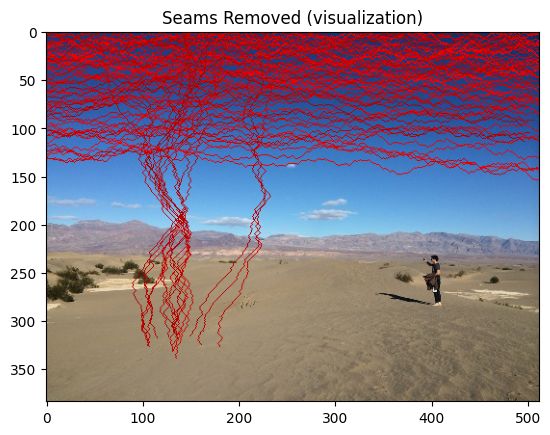

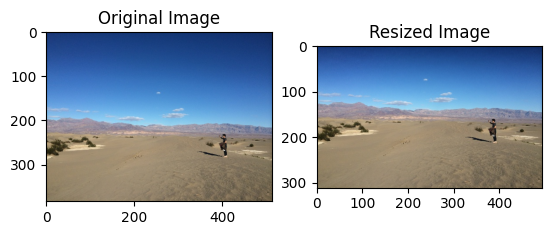

Original image shape: (384, 512, 3)
Resized image shape: (311, 495, 3)


In [ ]:
# Main code:

image = imread("C:/Users/Aya Elsheshtawy/Downloads/image6.jpg")

# Remove a total of 150 seams (each removal reduces width or height based on energy cost)
newImage = reduceImage(image, 90)

# Display the original and resized images side-by-side
f = plt.figure()
f.add_subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
f.add_subplot(1, 2, 2)
plt.imshow(newImage)
plt.title("Resized Image")
plt.show(block=True)

print("Original image shape:", image.shape)
print("Resized image shape:", newImage.shape)